## Resultados de clasificación

Presentamos los resultados de clasificación para los modelos analizados

- GPT-3.5
- Cohere/Aya
- Mixtral
- BETO -- modelo finetuneado



In [4]:

%load_ext autoreload
%autoreload 2
import pandas as pd
from glob import glob
pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)
from rioplatense_hs.preprocessing import text_to_label
from sklearn.metrics import classification_report

labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]
pred_labels = [f"PRED_{label}" for label in labels]

pred_labels = [f"PRED_{label}" for label in labels]
score_labels = [f"SCORE_{label}" for label in labels]

files = {
    #"one-shot": sorted(glob("../data/test*pred*1shot.csv")),
    "gpt-3.5": sorted(glob("../data/runs/test_*_chatgpt.csv")),
    "beto": sorted(glob("../data/runs/test*beto.csv")),
    "aya": sorted(glob("../data/runs/test*aya.csv")),
    "mixtral": sorted(glob("../data/runs/test*mixtral.csv")),
}

#assert len({len(value) for value in files.values()}) == 1

dfs = {k: pd.concat([pd.read_csv(f, index_col=0) for f in v]) for k, v in files.items()}

dfs["beto"][score_labels] = dfs["beto"][pred_labels]
dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)


for k, df in dfs.items():
    df["HATEFUL"] = (df[labels].sum(axis=1) > 0).astype(int)
    df["PRED_HATEFUL"] = (df[pred_labels].sum(axis=1) > 0).astype(int)

extended_labels = labels + ["HATEFUL"]


{k: v.shape for k, v in dfs.items()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'gpt-3.5': (5670, 24),
 'beto': (5670, 27),
 'aya': (5670, 25),
 'mixtral': (5670, 25)}

Calculamos intervalos de confianza para cada métrica

In [9]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score


def get_metrics(dfs, labels):
    metrics = []
    for name, df in dfs.items():
        print(name)
        for label in tqdm(labels):

            for metric in {"precision", "recall", "f1"}:
                if metric == "precision":
                    score = precision_score
                elif metric == "recall":
                    score = recall_score
                elif metric == "f1":
                    score = f1_score


                gold_labels = df[label].values
                preds = df[f"PRED_{label}"].values

                bst = Bootstrap(metric=score, num_bootstraps=150)

                bst_scores = bst.run(preds, gold_labels)

                for score in bst_scores:
                    metrics.append(
                        {
                            "model": name,
                            "label": label,
                            "metric": metric,
                            "score": score,
                        }
                    )

    return pd.DataFrame(metrics)

metrics = get_metrics(dfs, labels=extended_labels)


gpt-3.5


  0%|          | 0/5 [00:00<?, ?it/s]

beto


  0%|          | 0/5 [00:00<?, ?it/s]

aya


  0%|          | 0/5 [00:00<?, ?it/s]

mixtral


  0%|          | 0/5 [00:00<?, ?it/s]

In [26]:


model_order = ["aya", "mixtral", "gpt-3.5",  "beto"]


In [70]:
pd.options.display.float_format = "{:.4f}".format

pd.options.display.max_rows = 100

binary_metrics = metrics.loc[metrics["label"] == "HATEFUL"].copy()
del binary_metrics["label"]

def build_table(labels, join=" ± "):
    sub_metrics = metrics.loc[metrics["label"].isin(labels)].copy()
    if len(labels) == 1:
        group_columns = ["metric"]
        del sub_metrics["label"]
    else:
        group_columns = ["label", "metric"]


    mean_table = sub_metrics.pivot_table(index="model", columns=group_columns, values="score", aggfunc="mean") * 100
    std_table = sub_metrics.pivot_table(index="model", columns=group_columns, values="score", aggfunc="std") * 100

    # Change metrics to be ordered by precision, recall, f1



    res = mean_table.round(1).astype(str) + join + std_table.round(1).astype(str)

    if len(group_columns) == 1:
        res = res[["precision", "recall", "f1"]]
    else:
        res = res.reorder_levels(["metric", "label"], axis=1)[["precision", "recall", "f1"]].reorder_levels(["label", "metric"], axis=1)[labels]

    return res.loc[model_order]


binary_table = build_table(["HATEFUL"])

binary_table

metric,precision,recall,f1
model,,,
aya,11.9 ± 0.5,93.0 ± 1.2,21.2 ± 0.8
mixtral,25.1 ± 1.0,83.8 ± 1.7,38.6 ± 1.3
gpt-3.5,39.2 ± 1.8,61.2 ± 2.2,47.8 ± 1.8
beto,72.9 ± 2.4,56.3 ± 2.1,63.5 ± 1.8


In [71]:

binary_table = build_table(["HATEFUL"], join=" \pm ")


# Replace the ± with a \pm
for col in binary_table.columns:
    binary_table[col] = binary_table[col].map(lambda x:  "$" + x + "$")

binary_table = binary_table.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'midrule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False)

print(binary_table.to_latex())

\begin{tabular}{llll}
\hline
metric & precision & recall & f1 \\
model &  &  &  \\
\hline
aya & $11.9 \pm 0.5$ & $93.0 \pm 1.2$ & $21.2 \pm 0.8$ \\
mixtral & $25.1 \pm 1.0$ & $83.8 \pm 1.7$ & $38.6 \pm 1.3$ \\
gpt-3.5 & $39.2 \pm 1.8$ & $61.2 \pm 2.2$ & $47.8 \pm 1.8$ \\
beto & $72.9 \pm 2.4$ & $56.3 \pm 2.1$ & $63.5 \pm 1.8$ \\
\hline
\end{tabular}



In [47]:
all_table = build_table(labels)

all_table.reorder_levels(["metric", "label"], axis=1)[["precision", "recall", "f1"]].reorder_levels(["label", "metric"], axis=1)[labels]

label         WOMEN                               LGBTI              \
metric    precision      recall          f1   precision      recall   
model                                                                 
aya       9.7 ± 1.0  59.4 ± 4.1  16.7 ± 1.6  12.1 ± 1.4  78.7 ± 4.5   
mixtral  18.0 ± 1.7  74.9 ± 3.7  29.0 ± 2.3  33.2 ± 3.4  73.9 ± 5.4   
gpt-3.5  28.9 ± 3.3  40.8 ± 4.3  33.8 ± 3.4  43.2 ± 4.7  59.4 ± 5.5   
beto     58.2 ± 5.5  34.2 ± 4.1  43.0 ± 4.2  58.8 ± 6.4  37.6 ± 5.1   

label                    RACISM                               CLASS  \
metric           f1   precision      recall          f1   precision   
model                                                                 
aya      20.9 ± 2.2  20.0 ± 1.3  87.1 ± 2.1  32.5 ± 1.7   3.2 ± 0.4   
mixtral  45.7 ± 3.9  37.3 ± 2.2  83.9 ± 2.6  51.6 ± 2.3  11.3 ± 1.6   
gpt-3.5  49.9 ± 4.4  46.8 ± 2.8  68.2 ± 2.9  55.5 ± 2.5  22.8 ± 3.4   
beto     45.7 ± 5.1  80.2 ± 2.8  70.0 ± 2.9  74.7 ± 2.2  73.8 ± 6.6   

label                            
metric       recall          f1  
model                            
aya      58.2 ± 5.4   6.1 ± 0.8  
mixtral  59.5 ± 5.8  18.9 ± 2.5  
gpt-3.5  46.4 ± 6.1  30.4 ± 4.0  
beto     47.7 ± 5.8  57.7 ± 5.2

Estaría bueno calcular un p-valor en LGBTI para ver si la diferencia es significativa

In [31]:
# Es significativa la diferencia en LGBTI entre GPT-3.5 y BETO en términos de F1?
# Mann-Whitney U test
from scipy.stats import mannwhitneyu

lgbti_gpt = metrics[(metrics["label"] == "LGBTI") & (metrics["model"] == "gpt-3.5") & (metrics["metric"] == "f1")]["score"].values
lgbti_beto = metrics[(metrics["label"] == "LGBTI") & (metrics["model"] == "beto") & (metrics["metric"] == "f1")]["score"].values
lgbti_mixtral = metrics[(metrics["label"] == "LGBTI") & (metrics["model"] == "mixtral") & (metrics["metric"] == "f1")]["score"].values

mannwhitneyu(lgbti_gpt, lgbti_beto, alternative="greater")

MannwhitneyuResult(statistic=16386.5, pvalue=4.052462513071501e-12)

In [32]:
mannwhitneyu(lgbti_mixtral, lgbti_beto, alternative="greater")

MannwhitneyuResult(statistic=11257.5, pvalue=0.49628275389136395)

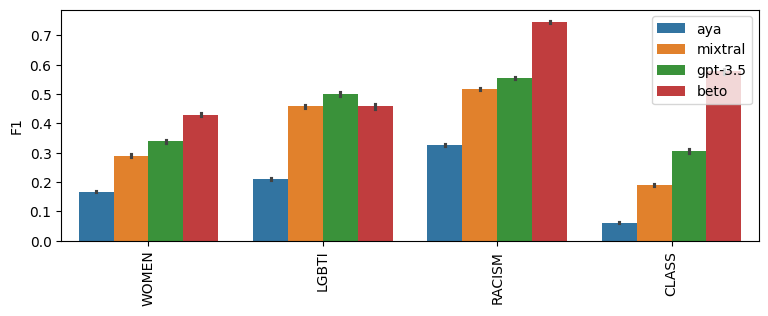

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot


model_order = ["aya", "mixtral", "gpt-3.5", "beto"]

def plot_metric(df, metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df[(df["metric"] == metric) & (df["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order, order=labels)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "f1"
plot_metric(df_metrics, metric, labels)
plt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

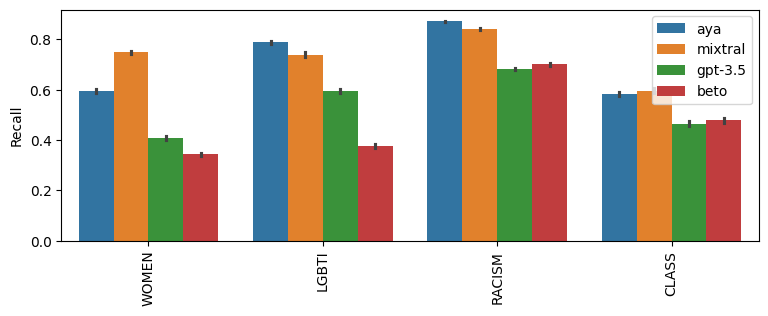

In [45]:
plot_metric(df_metrics, "recall", labels)
plt.savefig(f"img/recall.png", bbox_inches='tight', dpi=300)

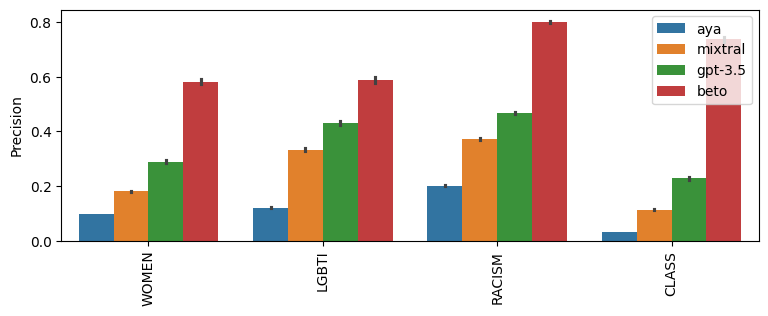

In [46]:
plot_metric(df_metrics, "precision", labels)
plt.savefig(f"img/precision.png", bbox_inches='tight', dpi=300)

## Métricas agrupadas

¿Cómo funciona esto si no miramos qué categorías marca un clasificador, sino simplemente binarizamos las salidas?

In [33]:
# Just keep the most important characteristics

hate_metrics = []

# If set to True, uses all labels. If not, only WOMEN, LGBTI, RACISM, CLASS
evaluate_all = False


for name, df in dfs.items():
    if not evaluate_all:
        label_hate = df[labels].sum(axis=1) > 0
        pred_hate = df[pred_labels].sum(axis=1) > 0
    else:
        label_hate = df[all_labels].sum(axis=1) > 0
        pred_hate = df[all_pred_labels].sum(axis=1) > 0
    for metric in {"precision", "recall", "f1"}:
        if metric == "precision":
            score = precision_score
        elif metric == "recall":
            score = recall_score
        elif metric == "f1":
            score = f1_score


        gold_labels = label_hate.values
        preds = pred_hate.values

        bst = Bootstrap(metric=score, num_bootstraps=150)

        bst_scores = bst.run(preds, gold_labels)

        for score in bst_scores:
            hate_metrics.append(
                {
                    "model": name,
                    "metric": metric,
                    "score": score,
                }
            )

hate_metrics = pd.DataFrame(hate_metrics)

hate_metrics

,model,metric,score
0,gpt-3.5,f1,0.4818
1,gpt-3.5,f1,0.4877
2,gpt-3.5,f1,0.4785
3,gpt-3.5,f1,0.4751
4,gpt-3.5,f1,0.5000
...,...,...,...
1795,mixtral,recall,0.8173
1796,mixtral,recall,0.8565
1797,mixtral,recall,0.8435
1798,mixtral,recall,0.8440


([0, 1, 2], [Text(0, 0, 'f1'), Text(1, 0, 'precision'), Text(2, 0, 'recall')])

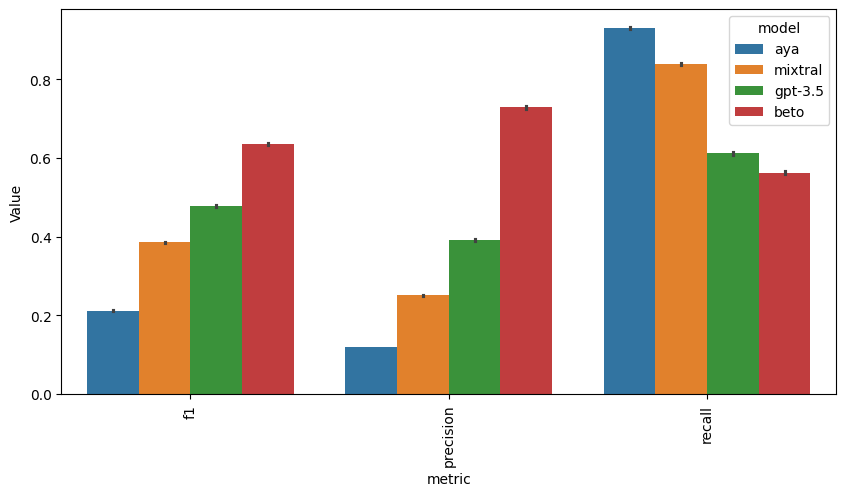

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

plt.figure(figsize=(10, 5))
sns.barplot(x='metric', y='score', hue='model', data=hate_metrics, hue_order=model_order)


plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()

In [35]:

# Show as mean +/- std
metrics_copy = hate_metrics.copy()

metrics_copy["score"] *= 100

res = metrics_copy.groupby(["model", "metric"]).mean().round(1).astype(str) + " +- " + metrics_copy.groupby(["model", "metric"]).std().round(1).astype(str)

# Show as mean +/- std with models as columns

res = res.reset_index().pivot(index="metric", columns="model", values="score")

res.loc[['precision', 'recall', 'f1'], ["aya", "mixtral", "gpt-3.5", "beto"]]

model,aya,mixtral,gpt-3.5,beto
metric,,,,
precision,11.9 +- 0.5,25.1 +- 1.0,39.2 +- 1.8,72.9 +- 2.4
recall,93.0 +- 1.2,83.8 +- 1.7,61.2 +- 2.2,56.3 +- 2.1
f1,21.2 +- 0.8,38.6 +- 1.3,47.8 +- 1.8,63.5 +- 1.8
